In [1]:
import librosa
from librosa import feature
from librosa import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.cluster import DBSCAN

In [2]:
x, sr=librosa.load("mixed_data\mixed_clip_15_happy_18_sad_18_disgust_24_fearful.wav", sr=None)
print(sr)

48000


In [3]:
nonMuteSections = librosa.effects.split(x, frame_length=sr//2)  # split audio with any audio signal lesser than 20db as mute
nonMuteSections

array([[  6656, 132608],
       [187904, 305152],
       [372736, 533504],
       [576512, 719360]])

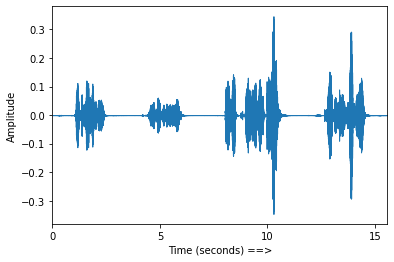

In [4]:
# displays original waveform
plt.figure()
display.waveplot(y=x, sr=sr)
plt.xlabel("Time (seconds) ==>")
plt.ylabel("Amplitude")
plt.show()

In [5]:
# same extraction function as in preprocessing notebook

def get_feature_vector(y, sr):
    feature_vector = []
    
    # multi-dim features
    feature_vector.extend(np.mean(feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1))
    feature_vector.extend(np.mean(feature.chroma_stft(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.spectral_contrast(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),axis=1))
    feature_vector.extend(np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1))
    
    # single-dim features with special requirements
    feature_vector.append(np.mean(feature.rms(y=y)))
    feature_vector.append(np.mean(feature.zero_crossing_rate(y=y)))
    feature_vector.extend([np.mean(x) for x in librosa.piptrack(y=y, sr=sr)])
    
    # single-dim features
    feat_list = [
        librosa.onset.onset_strength,
        feature.spectral_rolloff,
        feature.melspectrogram,
        feature.spectral_centroid,
        feature.spectral_bandwidth
    ]
    
    for temp_func in feat_list:
        feature_vector.append(np.mean(temp_func(y=y, sr=sr)))
    
    return feature_vector

Using sr: 48000
0.00s to 2.90s


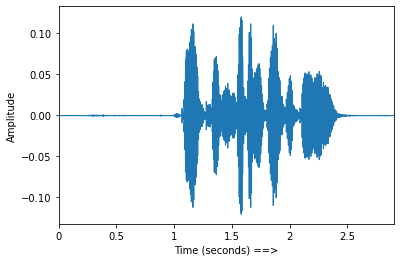

3.64s to 6.64s


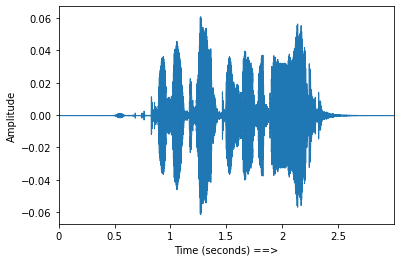

7.49s to 11.39s


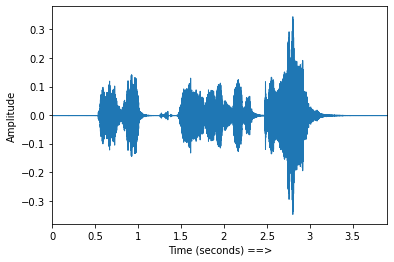

12.00s to 15.00s


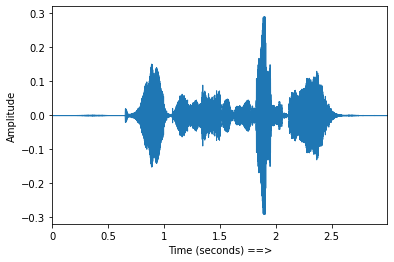

In [7]:
audio_features = []
print("Using sr:", sr)
for i in range(nonMuteSections.shape[0]):
    current_slice_len = nonMuteSections[i][1]-nonMuteSections[i][0]
    ideal_len = 3*sr  # 3 second ideal clip len
    # finding maximum possible delta to add to both sides to make a clip have as close to 3s length as possible
    if ideal_len>current_slice_len:
        delta = int((ideal_len-current_slice_len)/2)
        delta = min(delta, nonMuteSections[i][0])
        delta = min(delta, (len(x)-1-nonMuteSections[i][1]))
        # making sure we don't add more than 0.5s, since that could spill over into another person's voice
        delta = min(sr//2, delta)  # assuming split was made on 0.5s of silence as minimum
    slice=x[nonMuteSections[i][0]-delta:nonMuteSections[i][1]+delta]
    print('{:.2f}s to {:.2f}s'.format((nonMuteSections[i][0]-delta)/sr, (nonMuteSections[i][1]+delta)/sr))
    feature_vector = get_feature_vector(slice, sr)
    audio_features.append(feature_vector)
    
    # displaying waveform of slice
    plt.figure()
    display.waveplot(y=slice, sr=sr)
    plt.xlabel("Time (seconds) ==>")
    plt.ylabel("Amplitude")
    plt.show()

In [8]:
minMax = pd.read_pickle('Speaker_Classification_data/minMax.df')
minMax

,0,1,2,3,4,5,6,7,8,9,...,165,166,167,168,169,170,171,172,173,174
min,-873.242310,18.962200,-51.987183,-17.522383,-22.980276,-11.918348,-29.965725,-16.973310,-21.486086,-21.428455,...,1.692426e-09,0.000328,0.027717,2.918853,0.000270,0.774896,4998.104889,0.000077,2604.486405,2753.455274
max,-333.377991,115.150726,22.751472,36.544689,21.137091,28.005917,10.136993,16.415524,6.143632,7.424147,...,1.918034e-07,0.088504,0.168519,56.945759,0.118322,1.711348,14629.079312,4.081514,7654.876393,6367.981144


In [9]:
scaled_features=[]
for i in range(len(audio_features)):
    # calculating scaled features for a single slice
    scaled_slice=[]
    for j in range(len(audio_features[i])):
        # scaling each feature with the appropriate min and max
        scaled=(audio_features[i][j]-minMax[j]['min'])/(minMax[j]['max']-minMax[j]['min'])
        scaled_slice.append(scaled)
    scaled_features.append(scaled_slice)

In [10]:
model = keras.models.load_model("models/base_siamese_175")
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 175)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 175)]        0           []                               
                                                                                                  
 model (Functional)             (None, 100)          21924       ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dot (Dot)                      (None, 1)            0           ['model[0][0]',            

In [11]:
model.predict([np.array([scaled_features[1]]), np.array([scaled_features[2]])])[0][0]  # same actor, different emotions

0.9994035

In [12]:
model.predict([np.array([scaled_features[0]]), np.array([scaled_features[1]])])[0][0]  # different actors

-0.013504066

## Predicting clusters for speakers

In [13]:
model_inputs = [np.array([f]) for f in scaled_features]
# initialize distance matrix with 1s
distance_matrix = [[1 for _ in range(len(model_inputs))] for _ in range(len(model_inputs))]

for i in range(len(model_inputs)):
    for j in range(i, len(model_inputs)):
        # getting cosine distance = 1 - cosine similarity (predicted by siamese model)
        temp_dist = 1 - model.predict([model_inputs[i], model_inputs[j]])[0][0]
        temp_dist = max(temp_dist, 0)  # keeping everything >=0, sometimes dips below due to rounding errors otherwise
        distance_matrix[i][j] = temp_dist
        distance_matrix[j][i] = temp_dist

# printing distance_matrix
for row in distance_matrix:
    for item in row:
        print('%.2f'%item, end='\t')
    print()


0.00	1.01	1.01	1.01	
1.01	0.00	0.00	1.04	
1.01	0.00	0.00	1.05	
1.01	1.04	1.05	0.00	


In [14]:
cluster = DBSCAN(eps=0.25, min_samples=1, metric='precomputed').fit(distance_matrix)
pred_clusters = cluster.labels_
print(pred_clusters)

[0 1 1 2]
